# Boundary Modeling

The following notebook is comprised of 7 primary steps:
1. Initialize required packages, directories and parameters
2. Load and inspect the domain indicator data
3. Calculate and model the boundary indicator variogram
4. Calculate and model the Gaussian variogram that yields the indicator variogram when truncated
5. Model the distance function
6. Simulate boundary realizations, through truncation of simulated distance function deviates
7. Save project setting and clean the output files

## 1. Initialize required packages and parameters

In [1]:
import pygeostat as gs
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

### Project settings
Load the previously set Matplotlib and Pygeostat settings.

In [2]:
gs.Parameters['data.griddef'] = gs.GridDef('''
120 5.0 10.0 
110 1205.0 10.0 
1 0.5 1.0''')

gs.Parameters['data.catdict'] = {1: 'Inside', 0: 'Outside'}

# Data values
gs.Parameters['data.tmin'] = -998
gs.Parameters['data.null'] = -999

# Color map settings
gs.Parameters['plotting.cmap'] = 'bwr'
gs.Parameters['plotting.cmap_cat'] = 'bwr'

# Number of realizations
nreal = 100
gs.Parameters['data.nreal'] = nreal

# Parallel Processing threads
gs.Parameters['config.nprocess'] = 4

# Pot Style settings
gs.PlotStyle['legend.fontsize'] = 12
gs.PlotStyle['font.size'] = 11

### Directories

In [3]:
# Create the output directory
outdir = 'Output/'
gs.mkdir(outdir)

## 2. Load and Inspect the Boundary Data

Note that content in this section was explained in the introduction notebooks. Only new concepts are generally annotated in detail.

### Load the data and note its attributes

In [4]:
dat = gs.ExampleData('reservoir_boundary', cat='Domain Indicator')
dat.info

DataFile: c:\users\mostafahadavand\anaconda3\envs\pygeostat_public\lib\site-packages\pygeostat\data\example_data\reservoir_boundary.dat
Attributes:
dh: 'HoleID',  x: 'X',  y: 'Y',  cat: 'Domain Indicator',  



### Data content and summary statistics

In [5]:
print(dat.describe())
dat.head()

           HoleID            X            Y  Domain Indicator
count  301.000000   301.000000   301.000000        301.000000
mean   151.000000   585.313156  1743.896678          0.764120
std     87.035433   326.620938   290.727190          0.425255
min      1.000000     5.370000  1205.440000          0.000000
25%     76.000000   325.710000  1495.580000          1.000000
50%    151.000000   605.210000  1735.870000          1.000000
75%    226.000000   835.830000  1985.890000          1.000000
max    301.000000  1185.420000  2285.760000          1.000000


,HoleID,X,Y,Domain Indicator
0,1.0,85.36,1575.28,0.0
1,2.0,1105.62,1225.45,0.0
2,3.0,405.63,2135.75,1.0
3,4.0,195.84,2185.05,0.0
4,5.0,235.89,1865.70,1.0


### Map of the indicator 

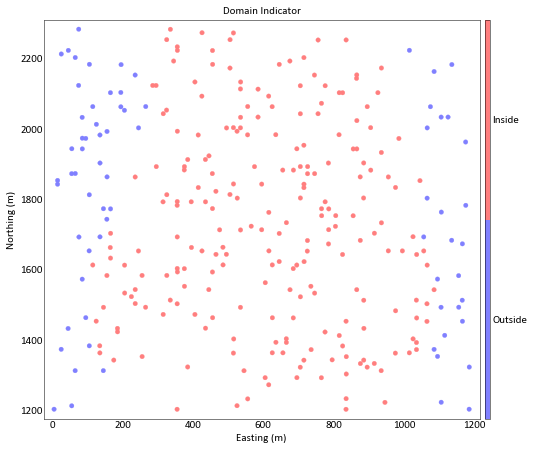

In [6]:
gs.location_plot(dat)

## 3. Calculate and Model the Indicator Variogram

The indicator variogram is calculated and modeled, since this is required input to calculation of the Gaussian variogram model in the next section (used for distance function $df$ modeling).

### Apply the variogram object for convenience
Variogram calculation, modeling, plotting and checking are readily accomplished with the variogram object, although unprovided parameters are inferred.

In [7]:
# get the proportions
proportion = sum(dat['Domain Indicator'])/len(dat)
print('Proportion of inside data: %.3f'%(proportion))

variance = proportion - proportion**2

Proportion of inside data: 0.764


In [8]:
# Perform data spacing analysis
dat.spacing(n_nearest=1)

In [9]:
lag_length = dat['Data Spacing (m)'].values.mean()
print('average data spacing in XY plane: {:.3f} {}'.format(lag_length,
                                                           gs.Parameters['plotting.unit']))

average data spacing in XY plane: 35.533 m


In [10]:
mean_range = (np.ptp(dat[dat.x].values) + np.ptp(dat[dat.y].values)) * 0.5
n_lag =  np.ceil((mean_range * 0.5) /  lag_length)
lag_tol = lag_length * 0.6

In [11]:
var_calc = gs.Program(program='varcalc')

In [12]:
parstr = """      Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{file}                             -file with data
2 3 0                              -   columns for X, Y, Z coordinates
1 4                                -   number of variables,column numbers (position used for tail,head variables below)
{t_min}    1.0e21                   -   trimming limits
{n_directions}                                  -number of directions
0.0 90 1000 0.0 22.5 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {n_lag}  {lag_length}  {lag_tol}            -        number of lags,lag distance,lag tolerance
{output}                          -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   10   1  {variance}        -tail variable, head variable, variogram type (and cutoff/category), sill
"""

n_directions = 1
varcalc_outfl = os.path.join(outdir, 'varcalc.out')

var_calc.run(parstr=parstr.format(file=dat.flname,
                                  n_directions = n_directions,
                                  t_min = gs.Parameters['data.tmin'],
                                  n_lag=n_lag,
                                  lag_length = lag_length,
                                  lag_tol = lag_tol,
                                  variance = variance,
                                  output=varcalc_outfl),
             liveoutput=True)

Calling:  ['varcalc', 'temp']

varcalc version:  1.002

  data file: 
 c:\users\mostafahadavand\anaconda3\envs\pygeostat_public\lib\site-packages\pyge
 ostat\data\example_data\reservoir_boundary.dat
  x,y,z columns:            2           3           0
  number of variables:            1
  Variable columns:            4
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   90.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          16   35.5325195368409     
   21.3195117221045     
  output file: Output/varcalc.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            1
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/categ

In [13]:
varfl = gs.DataFile(varcalc_outfl)
varfl.head()

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip,Variogram Type
0,1.0,14.690478,70.0,0.000000,1.0,0.0,0.0,10.0
1,1.0,39.861796,644.0,0.189532,1.0,0.0,0.0,10.0
2,1.0,73.396249,1433.0,0.236173,1.0,0.0,0.0,10.0
3,1.0,107.567881,1926.0,0.311110,1.0,0.0,0.0,10.0
4,1.0,142.941967,2472.0,0.311970,1.0,0.0,0.0,10.0


In [14]:
var_model = gs.Program(program='varmodel')

In [15]:
parstr = """      Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{varmodel_outfl}             -file for modeled variogram points output
1                            -number of directions to model points along
0.0   0.0  100   6          -  azm, dip, npoints, point separation
2    0.05                   -nst, nugget effect
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc_outfl}              -    experimental output file 1
1  1                          -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{varmodelfit_outfl}          -  file to save fit variogram model
"""

varmodel_outfl = os.path.join(outdir, 'varmodel.out')
varmodelfit_outfl = os.path.join(outdir, 'varmodelfit.out')

var_model.run(parstr=parstr.format(varmodel_outfl= varmodel_outfl,
                                   varmodelfit_outfl = varmodelfit_outfl,
                                   varcalc_outfl = varcalc_outfl), liveoutput=False, quiet=True)


In [16]:
varmdl = gs.DataFile(varmodel_outfl)
varmdl.head()

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip
0,1.0,6.0,1.0,0.062648,1.0,0.0,0.0
1,1.0,12.0,1.0,0.075294,1.0,0.0,0.0
2,1.0,18.0,1.0,0.087937,1.0,0.0,0.0
3,1.0,24.0,1.0,0.100573,1.0,0.0,0.0
4,1.0,30.0,1.0,0.113201,1.0,0.0,0.0


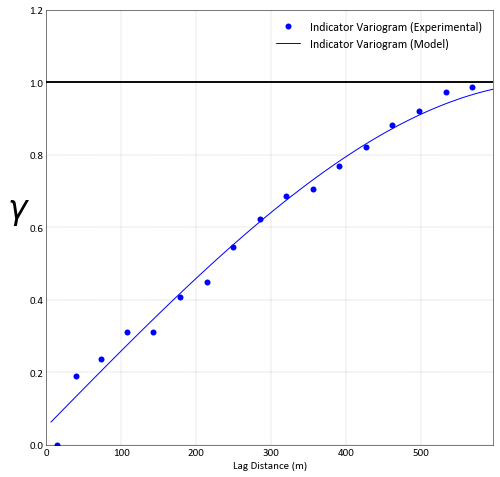

In [17]:
ax = gs.variogram_plot(varfl, index=1, color='b', grid=True, label = 'Indicator Variogram (Experimental)')
gs.variogram_plot(varmdl, index=1, ax=ax, color='b', experimental=False, label = 'Indicator Variogram (Model)')
_ = ax.legend(fontsize=12)

## 4. Calculate and model the Gaussian Variogram

The Gaussian variogram that yields the indicator variogram after truncation of a Gaussian random field is calculated. This Gaussian variogram is modeled and input to $df$ modeing. 

#### Calculate the Gaussian variogram
The bigaus2 program applies the Gaussian integration method, given the indicator variogram and the proportion of the indicator.

In [18]:
bigaus2 = gs.Program('bigaus2')

In [19]:
parstr = """                  Parameters for BIGAUS2
                                  **********************

START OF PARAMETERS:
1                                 -input mode (1) model or (2) variogram file
nofile.out                        -file for input variogram
{proportion}                      -threshold/proportion
2                                 -calculation mode (1) NS->Ind or (2) Ind->NS
{outfl}                           -file for output of variograms
1                                 -number of thresholds
{proportion}                      -threshold cdf values
1   {n_lag}                        -number of directions and lags
0   0.0   {lag_length}             -azm(1), dip(1), lag(1)
{varstr}
"""

with open(varmodelfit_outfl, 'r') as f:
    varmodel_ = f.readlines()
varstr = ''''''
for line in varmodel_:
    varstr += line

pars = dict(proportion=proportion,
            lag_length=lag_length,
            n_lag=n_lag,
            outfl= os.path.join(outdir, 'bigaus2.out'),
            varstr=varstr)
bigaus2.run(parstr=parstr.format(**pars), nogetarg=True)

Calling:  ['bigaus2', 'temp']

 BIGAUS2 Version: 2.200

 Which parameter file do you want to use?
  input mode =            1
  input file = nofile.out                              
  threshold probability =   0.7641196    
  calculation mode =            2
  output file = Output/bigaus2.out                      
  number of cutoffs =            1
  cutoffs =   0.7641196    
  ndir,nlag =            1          16
  azm, dip, lag =   0.0000000E+00  0.0000000E+00   35.53252    
  x,y,z offsets =   0.0000000E+00   35.53252      0.0000000E+00
  nst, c0 =            2  5.0000001E-02
  it,cc,ang[1,2,3] =             1  0.4364100      0.0000000E+00  0.0000000E+00
  0.0000000E+00
  a1 a2 a3 =    674.2867       284.332460000000        284.332460000000     
  it,cc,ang[1,2,3] =             1  0.5135900      0.0000000E+00  0.0000000E+00
  0.0000000E+00
  a1 a2 a3 =    677.3960       568.664930000000        568.664930000000     

 BIGAUS2 Version: 2.200 Finished




### Data manipulation to handle an odd data format
The bigaus2 program outputs an odd (legacyish) variogram format, which must be translated to the standard Variogram format.

In [20]:
# Read in the data before demonstrating its present form
expvargs = gs.readvarg(os.path.join(outdir, 'bigaus2.out'), 'all')
expvargs.head()

,Number,Distance,Value,Points,Head,Tail
0,1,0.000,0.000,1000,1.00000,0.00000
1,2,35.533,0.017,1000,0.98325,0.01675
2,3,71.065,0.043,1000,0.95741,0.04259
3,4,106.598,0.080,1000,0.92038,0.07962
4,5,142.130,0.127,1000,0.87304,0.12696


In [21]:
varclac_gaussian = gs.DataFile(data = varfl.data[:-1].copy(), flname=os.path.join(outdir,'gaussian_exp_variogram.out'))
varclac_gaussian['Lag Distance'] = expvargs['Distance']
varclac_gaussian['Variogram Value'] = expvargs['Value']
varclac_gaussian.write_file(varclac_gaussian.flname)
varclac_gaussian.head()

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip,Variogram Type
0,1.0,0.000,70.0,0.000,1.0,0.0,0.0,10.0
1,1.0,35.533,644.0,0.017,1.0,0.0,0.0,10.0
2,1.0,71.065,1433.0,0.043,1.0,0.0,0.0,10.0
3,1.0,106.598,1926.0,0.080,1.0,0.0,0.0,10.0
4,1.0,142.130,2472.0,0.127,1.0,0.0,0.0,10.0


### Gaussian variogram modeling
This model is input to distance function estimation.

In [22]:
parstr = """      Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{varmodel_outfl}             -file for modeled variogram points output
1                            -number of directions to model points along
0.0   0.0  100   6          -  azm, dip, npoints, point separation
2    0.01                   -nst, nugget effect
3    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
3    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc_outfl}              -    experimental output file 1
1 1                         -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{varmodelfit_outfl}          -  file to save fit variogram model
"""

varmodel_outfl_g = os.path.join(outdir, 'varmodel_g.out')
varmodelfit_outfl_g = os.path.join(outdir, 'varmodelfit_g.out')

var_model.run(parstr=parstr.format(varmodel_outfl= varmodel_outfl_g,
                                   varmodelfit_outfl = varmodelfit_outfl_g,
                                   varcalc_outfl = varclac_gaussian.flname), liveoutput=True, quiet=False)


Calling:  ['varmodel', 'temp']

varmodel version:  1.001

  output points file: Output/varmodel_g.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
         100   6.00000000000000     
  nst =           2
 c0 constrained to  1.000000000000000E-002  1.000000000000000E-002
  fit model?            1      100000
  number of variogram files:            1
  variogram file: Output/gaussian_exp_variogram.out
  using variograms            1
  # pairs wt, inv dist wt, min pairs:            1           0          10
  fixhmaxvert,hmaxvert:            0   10.0000000000000     
  fixhminhmax,hminhmax:            0   1.00000000000000     
  variogram model output file: Output/varmodelfit_g.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 Starting objective value =   0.186370051907448     
 Final objective value =   4.692203622701134E-004
  Modeling points


In [23]:
varmdl_g = gs.DataFile(varmodel_outfl_g)
varmdl_g.head()

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip
0,1.0,6.0,1.0,0.010233,1.0,0.0,0.0
1,1.0,12.0,1.0,0.010931,1.0,0.0,0.0
2,1.0,18.0,1.0,0.012094,1.0,0.0,0.0
3,1.0,24.0,1.0,0.013720,1.0,0.0,0.0
4,1.0,30.0,1.0,0.015806,1.0,0.0,0.0


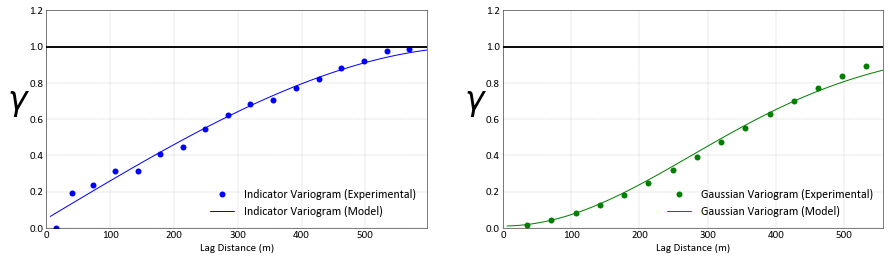

In [24]:
fig, axes = plt.subplots(1, 2, figsize= (15,4))

ax = axes[0]
ax = gs.variogram_plot(varfl, index=1, ax=ax, color='b', grid=True, label = 'Indicator Variogram (Experimental)')
gs.variogram_plot(varmdl, index=1, ax=ax, color='b', experimental=False, label = 'Indicator Variogram (Model)')
_ = ax.legend(fontsize=12)

ax = axes[1]
gs.variogram_plot(varclac_gaussian, index=1, ax=ax, color='g', grid=True, label = 'Gaussian Variogram (Experimental)')
gs.variogram_plot(varmdl_g, index=1, ax=ax, color='g', experimental=False, label = 'Gaussian Variogram (Model)')
_ = ax.legend(fontsize=12)

## 5. Distance Function $df$ Modeling

The $df$ is calculated at the data locations, before being estimated at the grid locations. The $c$ parameter is applied to the $df$ calculation, defining the bandwidth of uncertainty that will be simulated in the next section.

### Determine the $c$ parameter
Normally the optimal $c$ would be calculated using a jackknife study, but it is simply provided here.

In [25]:
selected_c = 200

### Calculate the $df$ at the data locations

In [26]:
dfcalc = gs.Program('dfcalc')

# Print the columns for populating the parameter file without variables
print(dat.columns)

Index(['HoleID', 'X', 'Y', 'Domain Indicator', 'Data Spacing (m)'], dtype='object')


In [27]:
parstr = """            Parameters for DFCalc
                           *********************
 
START OF PARAMETERS:
{datafl}                -file with input data
1 2 3 0 4               -column for DH,X,Y,Z,Ind
1                       -in code: indicator for inside domain
0.0  0.0  0.0           -angles for anisotropy ellipsoid
1.0  1.0                -first and second anisotropy ratios (typically <=1)
0                       -proportion of drillholes to remove
696969                  -random number seed
{c}                     -C
{outfl}                 -file for distance function output
'nofile.out'            -file for excluded drillholes output
"""
pars = dict(datafl=dat.flname, c=selected_c,
            outfl=os.path.join(outdir,'df_calc.out'))
dfcalc.run(parstr=parstr.format(**pars))

Calling:  ['dfcalc', 'temp']

 DFCalc Version: 1.001

  data file = c:\users\mostafahadavand\anaconda3\envs\
  columns =            1           2           3           0           4
  in code =            1
  anisotropy angles =   0.000000000000000E+000  0.000000000000000E+000
  0.000000000000000E+000
  anisotropy ratios =    1.00000000000000        1.00000000000000     
  proportion to exclude =   0.0000000E+00
  random number seed =       696969
  C =    200.0000    
  data file = Output/df_calc.out                      
  data file = 'nofile.out'                            
 
  Storing
 
  Calculating DF

 DFCalc Version: 1.001



### Manipulate the $df$ data before plotting
A standard naming convention of the distance function variable is used for convenience in the workflow, motivating the manipulation.

In [28]:
# Load the data and note the abbreviated name of the distance function
dat_df = gs.DataFile(os.path.join(outdir,'df_calc.out'), notvariables='Ind', griddef=gs.Parameters['data.griddef'])
print('Initial distance Function variable name = ', dat_df.variables)

# Set a standard distance function name
dfvar = 'Distance Function'
dat_df.rename({dat_df.variables:dfvar})
print('Distance Function variable name = ', dat_df.variables)

Initial distance Function variable name =  DF
Distance Function variable name =  Distance Function


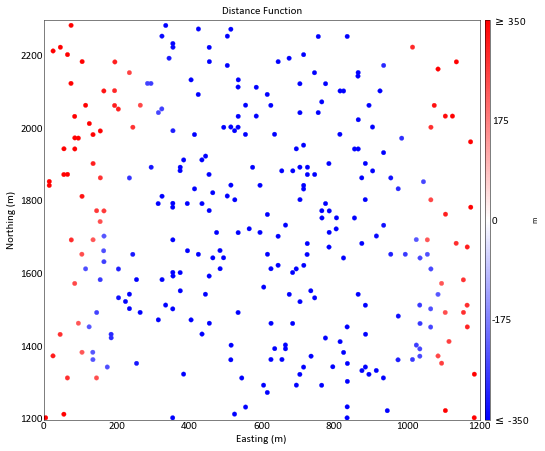

In [29]:
# Set symmetric color limits for the distance function
df_vlim = (-350, 350)
gs.location_plot(dat_df, vlim=df_vlim, cbar_label='m')

### Estimate the $df$ across the grid
Kriging is performed with a large number of data to provide a smooth  and conditionally unbiased estimate. Global kriging would also be appropriate.

In [30]:
kd3dn = gs.Program('kt3dn')

In [31]:
varmodelfit_outfl_g

'Output/varmodelfit_g.out'

In [32]:
parstr = """                 Parameters for KT3DN
                               ********************
START OF PARAMETERS:
{input_file}                     -file with data
1  2  3  0  6  0                 -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
nofile.out                       -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
{out_sum}                        -file for debugging output (see note)
{out_grid}                       -file for kriged output (see GSB note)
{gridstr}
1    1      1                    -x,y and z block discretization
1 100   100    1                 -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
700.0 700.0  500.0               -maximum search radii
 0.0   0.0   0.0                 -angles for search ellipsoid
1                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.0  0.6  0.8 1.6                -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
keyout.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
{varmodelstr}
"""

with open(varmodelfit_outfl_g, 'r') as f:
    varmodel_ = f.readlines()
varstr = ''''''
for line in varmodel_:
    varstr += line

pars = dict(input_file=os.path.join(outdir,'df_calc.out'), 
            out_grid=os.path.join(outdir,'kt3dn_df.out'),
            out_sum=os.path.join(outdir,'kt3dn_sum.out'),
            gridstr=gs.Parameters['data.griddef'], varmodelstr=varstr)
kd3dn.run(parstr=parstr.format(**pars))

Calling:  ['kt3dn', 'temp']

 KT3DN Version: 7.330

  data file = Output/df_calc.out                      
  columns =            1           2           3           0           6
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = xvk.dat                                 
  columns =            1           2           0           3           0
  data spacing analysis output file = nofile.out                              
  debugging level =            0
  debugging file = Output/kt3dn_sum.out                    
  GSLIB-style output file = Output/kt3dn_df.out                     
  nx, xmn, xsiz =          120   5.00000000000000        10.0000000000000     
  ny, ymn, ysiz =          110   1205.00000000000        10.0000000000000     
  nz, zmn, zsiz =            1  0.500000000000000        1.00000000000000     
  block discretization:           1           1           1
  ndmin,ndmax =            1  

### Manipulate and plot the $df$ estimate
pixelplt selects pointvar as the color of the overlain dat_df point data since its name matches the column name of est_df.

In [33]:
est_df = gs.DataFile(os.path.join(outdir,'kt3dn_df.out'))

# Drop the variance since we won't be using it, 
# allowing for specification of the column to be avoided 
est_df.drop('EstimationVariance')

# Rename to the standard distance function name for convenience
est_df.rename({est_df.variables:dfvar})
est_df.describe()

count    13200.000000
mean      -214.622337
std        355.715611
min       -672.659360
25%       -493.140375
50%       -355.400490
75%        190.427250
max        469.346690
Name: Distance Function, dtype: float64

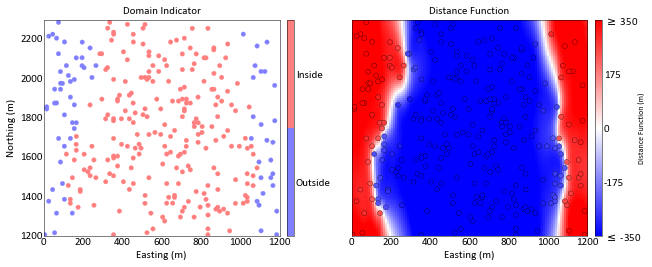

In [34]:
# Generate a figure object
fig, axes = gs.subplots(1, 2, figsize=(10, 8),cbar_mode='each', 
                        axes_pad=0.8,  cbar_pad=0.1)

# Location map of indicator data for comparison
gs.location_plot(dat, ax=axes[0])

# Map of distance function data and estimate
gs.slice_plot(est_df, pointdata=dat_df, 
            pointkws={'edgecolors':'k', 's':25},
            cbar_label='Distance Function (m)', vlim=df_vlim, ax=axes[1])

## 6. Boundary Simulation

This section is subdivided into 4 sub-sections:
1. Boot starp a value between -c and c using a uniform distribution
2. Transform this Gaussian deviate into $df$ deviates with a range of  $[−C, C]$
3. Add the $df$ deviates to the $df$ estimate, yielding a $df$ realization
4. Truncate the realization at  $df=0$ , generating a realization of the domain indicator 

In [35]:
# Required package for this calculation
from scipy.stats import norm

# Create a directory for the output
domaindir = os.path.join(outdir, 'Domains/')
gs.mkdir(domaindir)

for real in range(nreal):

    # Transform the Gaussian deviates to probabilities
    sim = np.random.rand()
    
    # Transform the probabilities to distance function deviates
    sim = 2 *selected_c * sim - selected_c

    # Initialize the final realization as the distance function estimate
    df = est_df[dfvar].values
    
    idx = np.logical_and(est_df[dfvar].values>selected_c, est_df[dfvar].values<selected_c)

    # Add the distance function deviates to the distance function estimate,
    # yielding a distance function realization
    df[idx] = df[idx] + sim

    # If the distance function is greater than 0, the simulated indicator is 1
    sim = (df <= 0).astype(int)

    # Convert the Numpy array to a Pandas DataFrame, which is required 
    # for initializing a DataFile (aside from the demonstrated flname approach).
    # The DataFile is then written out
    sim = pd.DataFrame(data=sim, columns=[dat.cat])
    sim = gs.DataFile(data=sim)
    sim.write_file(domaindir+'real{}.out'.format(real+1))

### Plot the realizations

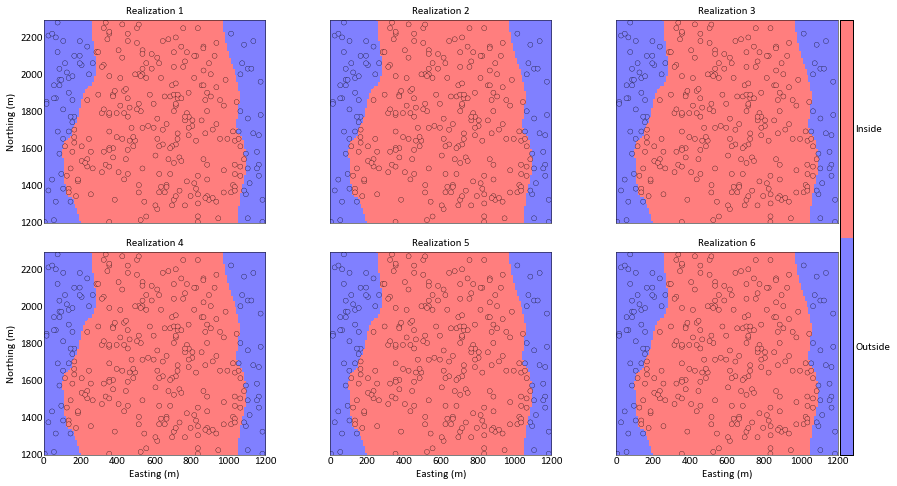

In [36]:
fig, axes = gs.subplots(2, 3, figsize=(15, 8), cbar_mode='single')
for real, ax in enumerate(axes):
    sim = gs.DataFile(domaindir+'real{}.out'.format(real+1))
    gs.slice_plot(sim, title='Realization {}'.format(real+1), 
                pointdata=dat, 
                pointkws={'edgecolors':'k', 's':25},
                vlim=(0, 1), ax=ax)

## 7. Save project settings and clean the output directory

In [37]:
gs.Parameters.save('Parameters.json')
gs.rmdir(outdir)
gs.rmfile('temp')